#Conversion Rate Analysis

Author: Jeff Horowitz


# Context
**Situation**

Advertisers are always working to optimize customer relevancy during the e-commerce transaction by experimenting with new ad campaigns, page layouts,and improvements in ML algorithms. They are interested in measuring metrics such as the uplift provided by conducting A/B tests with a treatment and a holdout (control) group. Using the dataset of a holdout experiment recently run, this advertiser is interested in measuring conversion rate per cohort and overall, plus value per transaction (VPT), and uplift. Below are the metric definitions:

$$
Conversion\;Rate_{Treatment}\;(CR_{T}) = {Unique\;Converted\;Users_{Treatment} \over Unique\;Users_{Treatment}}
$$
<br>
$$
Conversion\;Rate_{Control}\;(CR_{C}) = {Unique\;Converted\;Users_{Control} \over Unique\;Users_{Control}}
$$
<br>
$$
Conversion\;Rate_{Uplift} = {CR_{T}\;-\;CR_{C} \over CR_{C}}
$$
<br>
$$
Value\;Per\;Transaction(VPT) = {\sum_{s\in\{s\}}bidprice\_usd_{s}\over|S|}
$$
<br>
$$
S = {\{id\;|\;id\;is\;a\;unique\;sessionid\}}
$$

**Key Question**

After calculating the conversion rates, value per transaction, and uplift for each cohort and overall, identify if the campaign provides positive or negative impact and determine if the results are significant.

# 1. Load Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as model_selection
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

# 2. Data Loading and Pre-Processing
Let's begin by loading the data and doing some exploratory data analysis.

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Rokt/holdout_hKllMfFFdA.csv")

In [ ]:
data.head()

,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group,sessionid,userhash,value,verticalname
0,26-30,0.0,2020-02-01 00:01:39,202002,mobile,f,treatment,37348334365,e7j+F6Pk3JiuQi+y3HI0xX7mzuSY5tTohpQM0FZIWPU=,NaN,Ticketing
1,36-40,0.0,2020-02-01 00:04:09,202002,Mobile,f,treatment,37348334755,217xmeBlQVPlC4vVXRdpSFG1uvbA2ET6BL/TaPAK7mo=,NaN,Media and Entertainment
2,31-35,0.0,2020-02-01 00:04:37,202002,Mobile,f,treatment,37349334794,YZm04BwARD+mj0R0MEYuKeAf4l1ZIRsge2LumlsnmTQ=,NaN,Media and Entertainment
3,26-30,0.0,2020-02-01 00:04:41,202002,Mobile,f,treatment,37348334834,TR25fI0N1lOqSu2hadffCZ+SNIA6iY9BHAnIXAVXuxM=,NaN,Ticketing
4,36-40,0.0,2020-02-01 00:04:54,202002,Other,f,treatment,37348334883,+ufGey+TPBU8o2SjY+AXrNvocVGXKjQ+H8pqq7jQ8y8=,NaN,Media and Entertainment


In [ ]:
data.isna().sum()

,0
agegroup,0
bidprice_usd,0
campaigntimestamp,0
cohort,0
device,122
gender,90630
group,0
sessionid,0
userhash,0
value,873156


In [ ]:
data["device"] = data["device"].fillna("unk")
data["gender"] = data["gender"].fillna("unk")

In [ ]:
data.isna().sum()

,0
agegroup,0
bidprice_usd,0
campaigntimestamp,0
cohort,0
device,0
gender,0
group,0
sessionid,0
userhash,0
value,0


In [ ]:
data["value"] = data["value"].fillna(0)

In [ ]:
data["device"].value_counts()

,count
device,
Mobile,470187
Desktop,171011
mobile,110537
Tablet,99562
Other,37672
unk,122


In [ ]:
data["device"] = data["device"].str.lower()

In [ ]:
data["device"].value_counts()

,count
device,
mobile,580724
desktop,171011
tablet,99562
other,37672
unk,122


In [ ]:
data.head()

,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group,sessionid,userhash,value,verticalname
0,26-30,0.0,2020-02-01 00:01:39,202002,mobile,f,treatment,37348334365,e7j+F6Pk3JiuQi+y3HI0xX7mzuSY5tTohpQM0FZIWPU=,0.0,Ticketing
1,36-40,0.0,2020-02-01 00:04:09,202002,mobile,f,treatment,37348334755,217xmeBlQVPlC4vVXRdpSFG1uvbA2ET6BL/TaPAK7mo=,0.0,Media and Entertainment
2,31-35,0.0,2020-02-01 00:04:37,202002,mobile,f,treatment,37349334794,YZm04BwARD+mj0R0MEYuKeAf4l1ZIRsge2LumlsnmTQ=,0.0,Media and Entertainment
3,26-30,0.0,2020-02-01 00:04:41,202002,mobile,f,treatment,37348334834,TR25fI0N1lOqSu2hadffCZ+SNIA6iY9BHAnIXAVXuxM=,0.0,Ticketing
4,36-40,0.0,2020-02-01 00:04:54,202002,other,f,treatment,37348334883,+ufGey+TPBU8o2SjY+AXrNvocVGXKjQ+H8pqq7jQ8y8=,0.0,Media and Entertainment


In [ ]:
data["converted"] = data["value"].apply(lambda x: 1 if x > 0 else 0)
data.head()

,agegroup,bidprice_usd,campaigntimestamp,cohort,device,gender,group,sessionid,userhash,value,verticalname,converted
0,26-30,0.0,2020-02-01 00:01:39,202002,mobile,f,treatment,37348334365,e7j+F6Pk3JiuQi+y3HI0xX7mzuSY5tTohpQM0FZIWPU=,0.0,Ticketing,0
1,36-40,0.0,2020-02-01 00:04:09,202002,mobile,f,treatment,37348334755,217xmeBlQVPlC4vVXRdpSFG1uvbA2ET6BL/TaPAK7mo=,0.0,Media and Entertainment,0
2,31-35,0.0,2020-02-01 00:04:37,202002,mobile,f,treatment,37349334794,YZm04BwARD+mj0R0MEYuKeAf4l1ZIRsge2LumlsnmTQ=,0.0,Media and Entertainment,0
3,26-30,0.0,2020-02-01 00:04:41,202002,mobile,f,treatment,37348334834,TR25fI0N1lOqSu2hadffCZ+SNIA6iY9BHAnIXAVXuxM=,0.0,Ticketing,0
4,36-40,0.0,2020-02-01 00:04:54,202002,other,f,treatment,37348334883,+ufGey+TPBU8o2SjY+AXrNvocVGXKjQ+H8pqq7jQ8y8=,0.0,Media and Entertainment,0


In [ ]:
data["cohort"].value_counts()

,count
cohort,
202006,302757
202005,214188
202004,162761
202002,115940
202003,93444
203902,1


In [ ]:
data = data[data["cohort"] != 203902]

In [ ]:
data["cohort"].value_counts()

,count
cohort,
202006,302757
202005,214188
202004,162761
202002,115940
202003,93444


In [ ]:
data = data.drop_duplicates()

In [ ]:
data.shape

(846755, 12)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 846755 entries, 0 to 862230
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   agegroup           846755 non-null  object 
 1   bidprice_usd       846755 non-null  float64
 2   campaigntimestamp  846755 non-null  object 
 3   cohort             846755 non-null  int64  
 4   device             846755 non-null  object 
 5   gender             846755 non-null  object 
 6   group              846755 non-null  object 
 7   sessionid          846755 non-null  object 
 8   userhash           846755 non-null  object 
 9   value              846755 non-null  float64
 10  verticalname       846755 non-null  object 
 11  converted          846755 non-null  int64  
dtypes: float64(2), int64(2), object(8)
memory usage: 84.0+ MB


In [ ]:
data.describe()

,bidprice_usd,cohort,value,converted
count,846755.000000,846755.000000,846755.000000,846755.000000
mean,0.057986,202004.556833,2.752994,0.017971
std,0.254624,1.385441,657.058585,0.132846
min,0.000000,202002.000000,0.000000,0.000000
25%,0.000000,202004.000000,0.000000,0.000000
50%,0.000000,202005.000000,0.000000,0.000000
75%,0.000000,202006.000000,0.000000,0.000000
max,5.507550,202006.000000,466466.000000,1.000000


In [ ]:
data.nunique()

,0
agegroup,8
bidprice_usd,19456
campaigntimestamp,765040
cohort,5
device,5
gender,3
group,2
sessionid,773656
userhash,671795
value,3540


# 3. Overall Statistics

In [ ]:
# Conversion rates
group_summary = data.groupby('group').agg(
    unique_users=('userhash', 'nunique'),
    unique_converted_users=('userhash', lambda x: x[data['converted'] == 1].nunique())
)

group_summary['conversion_rate'] = group_summary['unique_converted_users'] / group_summary['unique_users']
group_summary.reset_index(inplace=True)
group_summary

,group,unique_users,unique_converted_users,conversion_rate
0,control,121750,2379,0.019540
1,treatment,576471,12833,0.022261


In [ ]:
# Uplift
conversionRate_treatment = group_summary.loc[group_summary["group"] =='treatment', 'conversion_rate'].iloc[0]
conversionRate_control = group_summary.loc[group_summary["group"] == 'control', 'conversion_rate'].iloc[0]
uplift = (conversionRate_treatment - conversionRate_control) / conversionRate_control

In [ ]:
# VPT
vpt_overall = data.groupby('group').agg(
    sum_bidprice = ('bidprice_usd', 'sum'),
    transactions = ("sessionid", "nunique")
)

vpt_overall["vpt"] = vpt_overall['sum_bidprice'] / vpt_overall['transactions']
vpt_overall.reset_index(inplace=True)
vpt_overall

,group,sum_bidprice,transactions,vpt
0,control,0.00000,126605,0.000000
1,treatment,49099.89138,647057,0.075882


# 4. Cohort Statistics

In [ ]:
# Conversion rates
cohort_summary = data.groupby(['cohort', 'group']).agg(
    unique_users=('userhash', 'nunique'),
    unique_converted_users=('userhash', lambda x: x[data['converted'] == 1].nunique())
)

cohort_summary['conversion_rate'] = cohort_summary['unique_converted_users'] / cohort_summary['unique_users']
cohort_summary.reset_index(inplace=True)
cohort_summary

,cohort,group,unique_users,unique_converted_users,conversion_rate
0,202002,control,28609,673,0.023524
1,202002,treatment,68908,2068,0.030011
2,202003,control,23822,551,0.023130
3,202003,treatment,57137,1680,0.029403
4,202004,control,29184,550,0.018846
5,202004,treatment,115316,2425,0.021029
6,202005,control,18736,293,0.015638
7,202005,treatment,170452,3100,0.018187
8,202006,control,25889,312,0.012051
9,202006,treatment,233631,3563,0.015251


In [ ]:
conversion_summary = cohort_summary
conversion_summary["cohort"] = conversion_summary["cohort"].astype(str)

In [ ]:
control_row = {
    'cohort': 'Overall',
    'group': 'control',
    'unique_users': group_summary.loc[group_summary['group'] == 'control', 'unique_users'].iloc[0],
    'unique_converted_users': group_summary.loc[group_summary['group'] == 'control', 'unique_converted_users'].iloc[0],
    'conversion_rate': group_summary.loc[group_summary['group'] == 'control', 'conversion_rate'].iloc[0]
}

In [ ]:
treatment_row = {
    'cohort': 'Overall',
    'group': 'treatment',
    'unique_users': group_summary.loc[group_summary['group'] == 'treatment', 'unique_users'].iloc[0],
    'unique_converted_users': group_summary.loc[group_summary['group'] == 'treatment', 'unique_converted_users'].iloc[0],
    'conversion_rate': group_summary.loc[group_summary['group'] == 'treatment', 'conversion_rate'].iloc[0]
}

In [ ]:
conversion_summary = pd.concat([conversion_summary, pd.DataFrame([control_row, treatment_row])], ignore_index=True)

In [ ]:
conversion_summary

,cohort,group,unique_users,unique_converted_users,conversion_rate
0,202002,control,28609,673,0.023524
1,202002,treatment,68908,2068,0.030011
2,202003,control,23822,551,0.023130
3,202003,treatment,57137,1680,0.029403
4,202004,control,29184,550,0.018846
5,202004,treatment,115316,2425,0.021029
6,202005,control,18736,293,0.015638
7,202005,treatment,170452,3100,0.018187
8,202006,control,25889,312,0.012051
9,202006,treatment,233631,3563,0.015251


In [ ]:
# VPT
vpt_cohort = data.groupby(['cohort', 'group']).agg(
    sum_bidprice=('bidprice_usd', 'sum'),
    transactions=('sessionid', 'nunique')
)

vpt_cohort['vpt'] = vpt_cohort['sum_bidprice'] / vpt_cohort['transactions']
vpt_cohort.reset_index(inplace=True)
vpt_cohort

,cohort,group,sum_bidprice,transactions,vpt
0,202002,control,0.00000,28682,0.000000
1,202002,treatment,7501.02665,69055,0.108624
2,202003,control,0.00000,23893,0.000000
3,202003,treatment,4908.70684,57296,0.085673
4,202004,control,0.00000,29290,0.000000
5,202004,treatment,8104.79071,115672,0.070067
6,202005,control,0.00000,18780,0.000000
7,202005,treatment,8307.10962,170850,0.048622
8,202006,control,0.00000,25960,0.000000
9,202006,treatment,20278.25756,234189,0.086589


In [ ]:
vpt_summary = vpt_cohort
vpt_summary["cohort"] = vpt_summary["cohort"].astype(str)
vpt_summary = vpt_summary[vpt_summary["group"] == "treatment"]
vpt_summary.drop(["group"], axis=1, inplace=True)
vpt_summary

<ipython-input-32-88edc969e8c3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vpt_summary.drop(["group"], axis=1, inplace=True)


,cohort,sum_bidprice,transactions,vpt
1,202002,7501.02665,69055,0.108624
3,202003,4908.70684,57296,0.085673
5,202004,8104.79071,115672,0.070067
7,202005,8307.10962,170850,0.048622
9,202006,20278.25756,234189,0.086589


In [ ]:
overall_vpt_row = {
    "cohort": "Overall",
    "sum_bidprice": vpt_overall.loc[vpt_overall["group"] == "treatment", "sum_bidprice"].iloc[0],
    "transactions": vpt_overall.loc[vpt_overall["group"] == "treatment", "transactions"].iloc[0],
}

overall_vpt_row["vpt"] = overall_vpt_row["sum_bidprice"] / overall_vpt_row["transactions"]

overall_vpt_row

{'cohort': 'Overall',
 'sum_bidprice': 49099.89138,
 'transactions': 647057,
 'vpt': 0.07588186416343537}

In [ ]:
vpt_summary = pd.concat([vpt_summary, pd.DataFrame([overall_vpt_row])], ignore_index=True)
vpt_summary

,cohort,sum_bidprice,transactions,vpt
0,202002,7501.02665,69055,0.108624
1,202003,4908.70684,57296,0.085673
2,202004,8104.79071,115672,0.070067
3,202005,8307.10962,170850,0.048622
4,202006,20278.25756,234189,0.086589
5,Overall,49099.89138,647057,0.075882


In [ ]:
# Uplift
uplift_summary = cohort_summary.drop(["unique_users", "unique_converted_users"], axis=1)
uplift_summary["cohort"] = uplift_summary["cohort"].astype(str)
uplift_summary

,cohort,group,conversion_rate
0,202002,control,0.023524
1,202002,treatment,0.030011
2,202003,control,0.023130
3,202003,treatment,0.029403
4,202004,control,0.018846
5,202004,treatment,0.021029
6,202005,control,0.015638
7,202005,treatment,0.018187
8,202006,control,0.012051
9,202006,treatment,0.015251


In [ ]:
uplift_summary = pd.pivot_table(uplift_summary, values='conversion_rate', index=['cohort'], columns=['group'])

In [ ]:
uplift_summary = pd.DataFrame(uplift_summary).reset_index()

In [ ]:
uplift_summary["uplift"] = (uplift_summary["treatment"] - uplift_summary["control"]) / uplift_summary["control"]
uplift_summary

group,cohort,control,treatment,uplift
0,202002,0.023524,0.030011,0.275759
1,202003,0.023130,0.029403,0.271213
2,202004,0.018846,0.021029,0.115846
3,202005,0.015638,0.018187,0.162971
4,202006,0.012051,0.015251,0.265453


In [ ]:
overall_uplift_row = {
    "cohort": "Overall",
    "control": conversionRate_control,
    "treatment": conversionRate_treatment,
    "uplift": uplift
}

In [ ]:
uplift_summary = pd.concat([uplift_summary, pd.DataFrame([overall_uplift_row])], ignore_index=True)
uplift_summary

,cohort,control,treatment,uplift
0,202002,0.023524,0.030011,0.275759
1,202003,0.023130,0.029403,0.271213
2,202004,0.018846,0.021029,0.115846
3,202005,0.015638,0.018187,0.162971
4,202006,0.012051,0.015251,0.265453
5,Overall,0.019540,0.022261,0.139266


# 5. Plotting

In [ ]:
def convert_to_month(value):
    try:
        return pd.to_datetime(str(value), format='%Y%m').strftime('%b')
    except ValueError:
        return value

<ipython-input-42-8baff9697e97>:5: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  ax = sns.barplot(x="cohort",


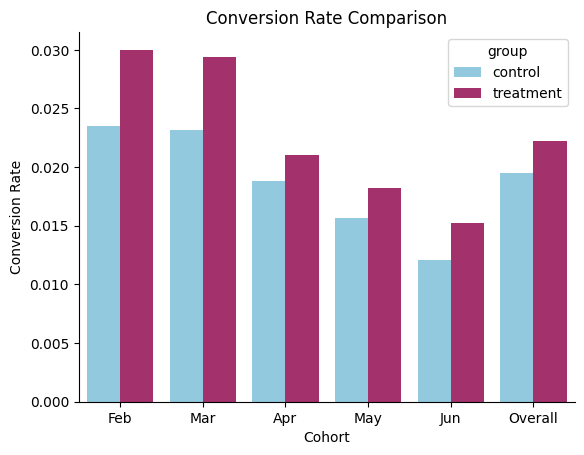

In [ ]:
conversion_summary["cohort"] = conversion_summary["cohort"].apply(convert_to_month)

colors = ["skyblue" if group != "treatment" else "#b51e6d" for group in conversion_summary["group"]]

ax = sns.barplot(x="cohort",
                 y="conversion_rate",
                 hue="group",
                 palette=colors,
                 data=conversion_summary)

plt.xlabel("Cohort")
plt.ylabel("Conversion Rate")
plt.title("Conversion Rate Comparison")

sns.despine()

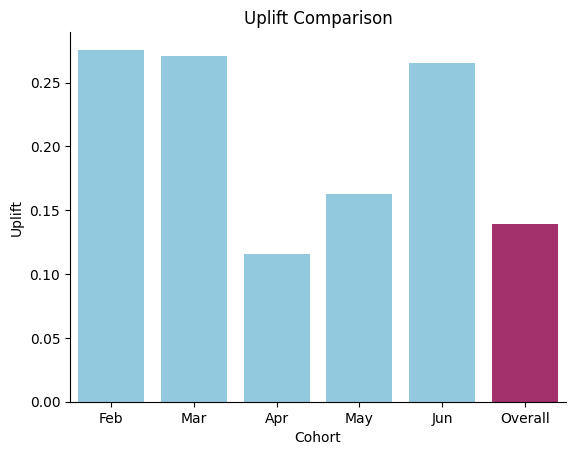

In [ ]:
uplift_summary["cohort"] = uplift_summary["cohort"].apply(convert_to_month)

colors = ["skyblue" if cohort != "Overall" else "#b51e6d" for cohort in uplift_summary["cohort"]]

ax = sns.barplot(
    x="cohort",
    y="uplift",
    data=uplift_summary,
    hue = "cohort",
    palette  = colors)

plt.xlabel("Cohort")
plt.ylabel("Uplift")
plt.title("Uplift Comparison")

sns.despine()

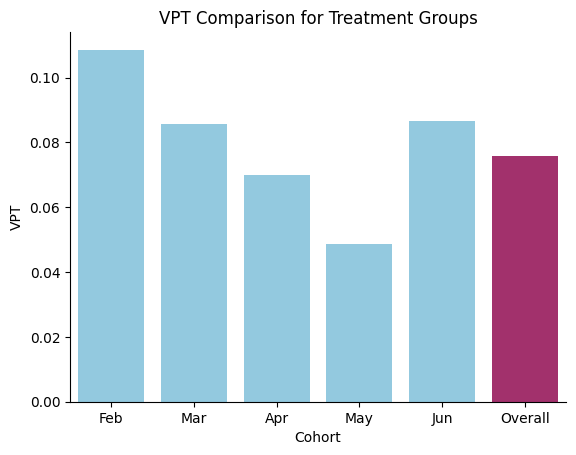

In [ ]:
vpt_summary["cohort"] = vpt_summary["cohort"].apply(convert_to_month)

colors = ["skyblue" if cohort != "Overall" else "#b51e6d" for cohort in vpt_summary["cohort"]]

ax = sns.barplot(x="cohort",
            y="vpt",
            data=vpt_summary,
            hue = "cohort",
            palette  = colors)

plt.xlabel("Cohort")
plt.ylabel("VPT")
plt.title("VPT Comparison for Treatment Groups")

sns.despine()

# 6. Determine Statistical Significance
Differences in Proportions Test

* Null - there is no difference in the conversion rates for the control and treatment groups

* Alternative - there is a difference in the conversion rates for the control and treatment groups

In [ ]:
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
group_summary

,group,unique_users,unique_converted_users,conversion_rate
0,control,121750,2379,0.019540
1,treatment,576471,12833,0.022261


In [ ]:
count = np.array([group_summary["unique_converted_users"][group_summary["group"] == "control"].iloc[0], group_summary["unique_converted_users"][group_summary["group"] == "treatment"].iloc[0]])
nobs = np.array(group_summary["unique_users"][group_summary["group"] == "control"].iloc[0], group_summary["unique_users"][group_summary["group"] == "treatment"].iloc[0])

stat, pval = proportions_ztest(count, nobs)

pval

0.0

# 7. Simple Logistic Regression

In [ ]:
regression_data = data[['agegroup','device','gender','verticalname','group','converted']]

In [ ]:
regression_data = pd.get_dummies(regression_data, columns=['agegroup','device','gender','verticalname','group'], drop_first = True, dtype = int)

In [ ]:
regression_data

,converted,agegroup_26-30,agegroup_31-35,agegroup_36-40,agegroup_41-45,agegroup_46-55,agegroup_56-65,agegroup_65+,device_mobile,device_other,...,gender_m,gender_unk,verticalname_Food and Beverage,verticalname_Loyalty and Samples,verticalname_Media and Entertainment,verticalname_Retail,verticalname_Sports and Fitness,verticalname_Ticketing,verticalname_Travel,group_treatment
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
3,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
846750,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
846751,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
846752,0,0,0,0,0,1,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
848141,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1


In [ ]:
x = regression_data.drop('converted', axis = 1)
y = regression_data['converted']

In [ ]:
model = LogisticRegression()
model.fit(x,y)

LogisticRegression()

In [ ]:
model.summary()

AttributeError: 'LogisticRegression' object has no attribute 'summary'

In [ ]:
model.coef_

array([[-0.15654963,  0.41881175,  0.57846781,  0.76064763,  0.9473181 ,
         0.84913618, -0.06730542, -0.06546822, -0.04209202, -0.12934908,
        -0.00777426, -0.60335031, -0.46947773, -0.98243888, -0.02765574,
        -1.00771676, -0.22800889,  0.00410455, -0.57375335, -0.4927943 ,
        -0.05401566]])

In [ ]:
log_clf = LogisticRegression()

log_clf = sm.Logit(y, x)

classifier = log_clf.fit()

Optimization terminated successfully.
         Current function value: 0.087344
         Iterations 9


In [ ]:
print(classifier.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               846755
Model:                          Logit   Df Residuals:                   846734
Method:                           MLE   Df Model:                           20
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                 0.02987
Time:                        21:07:09   Log-Likelihood:                -73959.
converged:                       True   LL-Null:                       -76237.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
agegroup_26-30                          -0.1037      0.035     -2.945      0.003      -0.173      -0.035
agegroup_31-35                           0.4133      

# 8. Conclusion

**Does the campaign provide a positive impact?**

* Conversion rates for treatment groups are higher for all cohorts and overall.

* Seasonality shows reduced treatment effect from April through June.

* Considering the overall conversion rates, the campaign provides a small positive impact as evidenced by the **0.2%** increase between the treatment and control groups.
<br>

**How can we measure the impact?**

* On average, users are **14%** more likely to convert when seeing an ad (see Uplit chart).

* On average, the advertiser pays **$0.08** to show an ad (see VPT chart).
<br>

**Are these results significant?**

To determine if the observed results are significant, we ran a difference in proportions test with the following hypotheses:

 * $H_{0}$: there is no difference in the conversion rates

 * $H_{a}$: there is a difference in the conversion rates

The test resulted in a p-value < 0.01 indicating statistical significance at the 99% level.

<br>

**What's next?**

 * Calculate and evaluate conversion rates, uplift, and VPT among other groups including device type, gender, age, and vertical.

 * Run a logistic regression to determine which of the features contribute to the difference in proportions observed.

    + Initial results indicate that the following segments are associated with higher conversions: females, age group 46-55, and the sports and fitness vertical.

    + Target the identified groups that drive the higher conversions (additional testing required to confirm results)

 * Continue to investigate the user segments to determine if there is any bias in the data (i.e., were users in the treatment group predetermined to convert whether they saw the ad or not).